In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve, auc

In [38]:
class DenseLayer:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    def forward(self, inputs):
        self.inputs = inputs  
        self.output = np.dot(inputs, self.weights) + self.biases
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class ReLU:
    def forward(self, inputs):
        self.inputs = inputs  
        self.output = np.maximum(0, inputs)
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Softmax:
    def forward(self, inputs):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        return np.mean(sample_losses)

class CategoricalCrossentropyLoss(Loss):
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(len(y_pred)), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

class SoftmaxLossCategoricalCrossentropy:
    def __init__(self):
        self.activation = Softmax()
        self.loss = CategoricalCrossentropyLoss()
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples


class OptimizerSGD:
    def __init__(self, learning_rate=1., decay=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
    def update_params(self, layer):
        layer.weights -= self.current_learning_rate * layer.dweights
        layer.biases -= self.current_learning_rate * layer.dbiases
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    def post_update_params(self):
        self.iterations += 1

In [39]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X_train = np.array(train.drop(['No-show'], axis=1))
y_train = np.array(train['No-show'])
X_test = np.array(test.drop(['No-show'], axis=1))
y_test = np.array(test['No-show'])

In [46]:
layer1 = DenseLayer(X_train.shape[1], 8)
activation1 = ReLU()
layer2 = DenseLayer(8, 16)
activation2 = ReLU()
layer3 = DenseLayer(16, 2)
loss_activation = SoftmaxLossCategoricalCrossentropy()
optimizer = OptimizerSGD(learning_rate=0.05)

In [47]:
losses = []
f1_scores = []

def forwardpass():    
    layer1.forward(X_train)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    loss = loss_activation.forward(layer3.output, y_train)
    return loss

def backwardpass():
    layer3.backward(loss_activation.dinputs)
    activation2.backward(layer3.dinputs)
    layer2.backward(activation2.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)

def optimizerupdate():
    optimizer.pre_update_params()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.update_params(layer3)
    optimizer.post_update_params()

In [48]:
epochs = 1000
for epoch in range(epochs):
    loss = forwardpass()
    predictions = np.argmax(loss_activation.output, axis=1)
    f1 = f1_score(y_train, predictions, average='macro')
    losses.append(loss)
    f1_scores.append(f1)
    loss_activation.backward(loss_activation.output, y_train)
    backwardpass()
    optimizerupdate()

    if epoch % 100== 0 or epoch== epochs-1:
        print(f'Epoch {epoch}: loss={loss:.4f}, F1 score={f1:.4f}')

Epoch 0: loss=0.6931, F1 score=0.3487
Epoch 100: loss=0.6931, F1 score=0.6285
Epoch 200: loss=0.6931, F1 score=0.6418
Epoch 300: loss=0.6931, F1 score=0.6424
Epoch 400: loss=0.6931, F1 score=0.6461
Epoch 500: loss=0.6931, F1 score=0.6525
Epoch 600: loss=0.6931, F1 score=0.6540
Epoch 700: loss=0.6931, F1 score=0.6545
Epoch 800: loss=0.6931, F1 score=0.6558
Epoch 900: loss=0.6931, F1 score=0.6560
Epoch 999: loss=0.6931, F1 score=0.6562


In [49]:
layer1.forward(X_test)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)
layer3.forward(activation2.output)
loss_activation.forward(layer3.output, y_test)
y_pred = np.argmax(loss_activation.output, axis=1)

In [50]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

precision, recall, _ = precision_recall_curve(y_test, loss_activation.output[:,1])
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.53      0.61     17642
           1       0.63      0.79      0.70     17642

    accuracy                           0.66     35284
   macro avg       0.67      0.66      0.66     35284
weighted avg       0.67      0.66      0.66     35284

Confusion Matrix:
 [[ 9409  8233]
 [ 3681 13961]]
PR-AUC: 0.6318


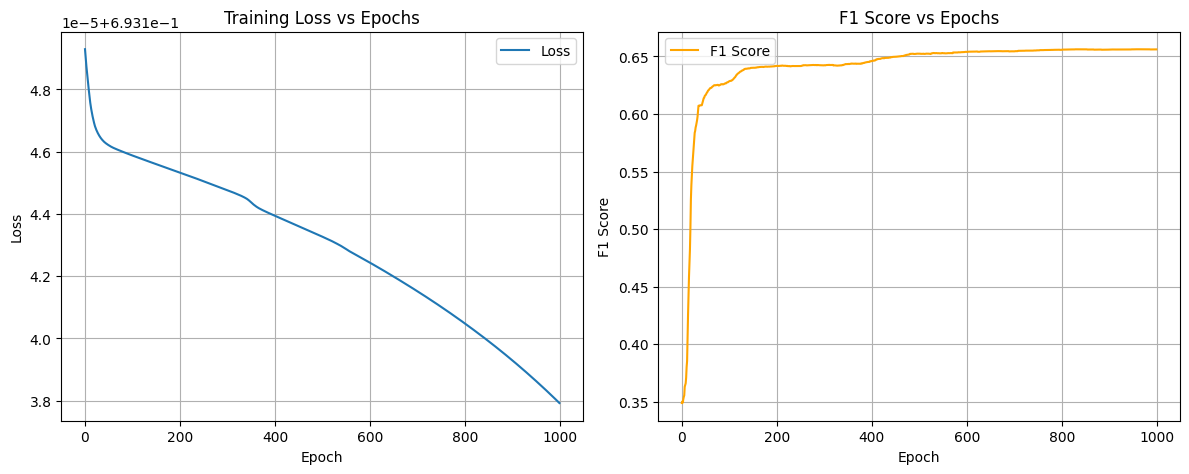

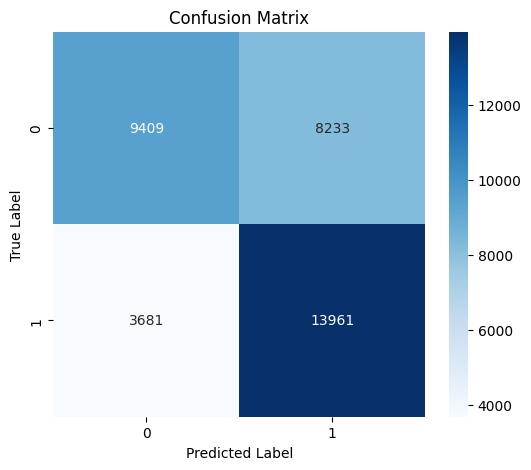

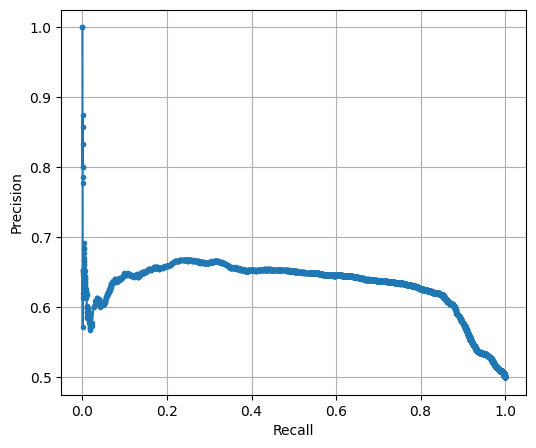

In [51]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(losses, label='Loss')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(f1_scores, label='F1 Score', color='orange')
plt.title('F1 Score vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(6,5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()